# Recommendation Engine

In this challenge we are required to build a model to predict the number of attempts taken  by participants for a successful submission to online programming challenges. Data of programmers and questions they solved previously were given along with the time they took to solve the questions. 

Input data contains three files:

**train_submissions.csv** - This contains 1,55,295 submissions which are selected randomly from 2,21,850 submissions. It contains 3 columns (‘user_id’, ‘problem_id’, ‘attempts_range’). The variable ‘attempts_range’ denotes the range of attempts that the users made to get the solution accepted which is our target. It takes values between 1 and 6.          

**user_data.csv** - This file contains data of users. It contains the following features :-
* user_id - unique ID assigned to each user
* submission_count - total number of user submissions
* problem_solved - total number of accepted user submissions
* contribution - user contribution to the judge
* country - location of user
* follower_count - amount of users who have this user in followers
* last_online_time_seconds - time when user was last seen online
* max_rating - maximum rating of user
* rating - rating of user
* rank - can be one of ‘beginner’ ,’intermediate’ , ‘advanced’, ‘expert’
* registration_time_seconds - time when user was registered
 

**problem_data.csv** - This file contains data of the problems. It contains the following features :-
* problem_id - unique ID assigned to each problem
* level_id - the difficulty level of the problem between ‘A’ to ‘N’
* points - amount of points for the problem
* tags - problem tag(s) like greedy, graphs, DFS etc.
 
Test data has one file:

**test_submissions.csv** - This contains the remaining 66,555 submissions from total 2,21,850 submissions. Contains 1 column (ID). The ‘attempts_range’ column which is to be predicted.



# This notebook contains:

* EDA
* Feature Engineering
* Modeling
* Submission

# Import necesary libraries

In [1]:
import numpy as np #linear algebra
import pandas as pd # data processing I/O CSV files

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud

from collections import Counter

#machine learning library
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, RandomizedSearchCV, train_test_split

#filter out warnings
import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [2]:
prob = pd.read_csv('../input/avrecommendation-system/AV-Recommendation Engine/train/problem_data.csv')
train = pd.read_csv('../input/avrecommendation-system/AV-Recommendation Engine/train/train_submissions.csv')
user = pd.read_csv('../input/avrecommendation-system/AV-Recommendation Engine/train/user_data.csv')
test = pd.read_csv('../input/avrecommendation-system/AV-Recommendation Engine/test_submissions_NeDLEvX.csv')
sub = pd.read_csv('../input/avrecommendation-system/AV-Recommendation Engine/sample_submission_SCGtj9F.csv')

In [3]:
train.head()

,user_id,problem_id,attempts_range
0,user_232,prob_6507,1
1,user_3568,prob_2994,3
2,user_1600,prob_5071,1
3,user_2256,prob_703,1
4,user_2321,prob_356,1


In [4]:
prob.head()

,problem_id,level_type,points,tags
0,prob_3649,H,NaN,NaN
1,prob_6191,A,NaN,NaN
2,prob_2020,F,NaN,NaN
3,prob_313,A,500.0,"greedy,implementation"
4,prob_101,A,500.0,"constructive algorithms,greedy,math"


In [5]:
user.head()

,user_id,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds
0,user_3311,47,40,0,NaN,4,1504111645,348.337,330.849,intermediate,1466686436
1,user_3028,63,52,0,India,17,1498998165,405.677,339.450,intermediate,1441893325
2,user_2268,226,203,-8,Egypt,24,1505566052,307.339,284.404,beginner,1454267603
3,user_480,611,490,1,Ukraine,94,1505257499,525.803,471.330,advanced,1350720417
4,user_650,504,479,12,Russia,4,1496613433,548.739,486.525,advanced,1395560498


In [6]:
test.head()

,ID,user_id,problem_id
0,user_856_prob_5822,user_856,prob_5822
1,user_2642_prob_2334,user_2642,prob_2334
2,user_2557_prob_2920,user_2557,prob_2920
3,user_1572_prob_4598,user_1572,prob_4598
4,user_295_prob_6139,user_295,prob_6139


The data is present in three tables - train, user, prob. Merge the data and have it in one table for analysis.

In [7]:
train = train.merge(prob, on='problem_id')
train = train.merge(user, on='user_id')

In [8]:
train.head()

,user_id,problem_id,attempts_range,level_type,points,tags,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds
0,user_232,prob_6507,1,B,1000.0,strings,53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935
1,user_232,prob_5071,4,A,500.0,implementation,53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935
2,user_232,prob_703,2,A,500.0,"brute force,implementation",53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935
3,user_232,prob_3935,1,C,1000.0,"greedy,sortings",53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935
4,user_232,prob_164,2,A,500.0,"brute force,constructive algorithms,math",53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935


All the data is present in one table - train. Now it can be used for analysis.

In [9]:
#test_ids = test.pop('ID') # save test IDs for submission
test = test.merge(prob, on='problem_id') # merge test data with user and prob data
test = test.merge(user, on='user_id')
test_ids = test.pop('ID') # save test IDs for submission

In [10]:
print(train.info())
print('='*50)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155295 entries, 0 to 155294
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   user_id                    155295 non-null  object 
 1   problem_id                 155295 non-null  object 
 2   attempts_range             155295 non-null  int64  
 3   level_type                 154675 non-null  object 
 4   points                     126220 non-null  float64
 5   tags                       139868 non-null  object 
 6   submission_count           155295 non-null  int64  
 7   problem_solved             155295 non-null  int64  
 8   contribution               155295 non-null  int64  
 9   country                    117442 non-null  object 
 10  follower_count             155295 non-null  int64  
 11  last_online_time_seconds   155295 non-null  int64  
 12  max_rating                 155295 non-null  float64
 13  rating                     15

**Check for null values**

In [11]:
print(train.isna().sum())

user_id                          0
problem_id                       0
attempts_range                   0
level_type                     620
points                       29075
tags                         15427
submission_count                 0
problem_solved                   0
contribution                     0
country                      37853
follower_count                   0
last_online_time_seconds         0
max_rating                       0
rating                           0
rank                             0
registration_time_seconds        0
dtype: int64


Both train and test datasets have null values. These have to be fixed since ML models will not accept NaN values. 

# Exploratory Data Analysis

**Distribution of target: attempts_range **

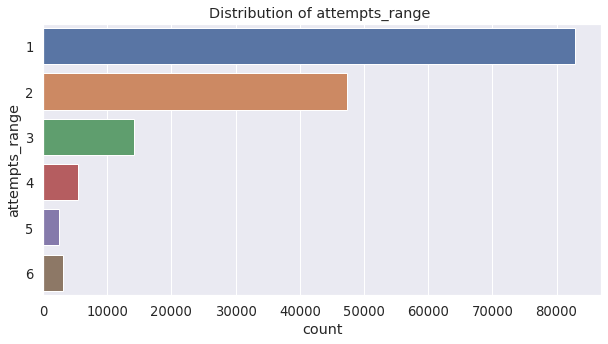

In [12]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.2)
sns.countplot(y='attempts_range', data=train).set_title('Distribution of attempts_range ')
plt.show()

**Problem level:** There are various levels of problems in this data. They are encoded into letters A to N and specified in level_type column. The problem levels probably indicate the difficulty level. 

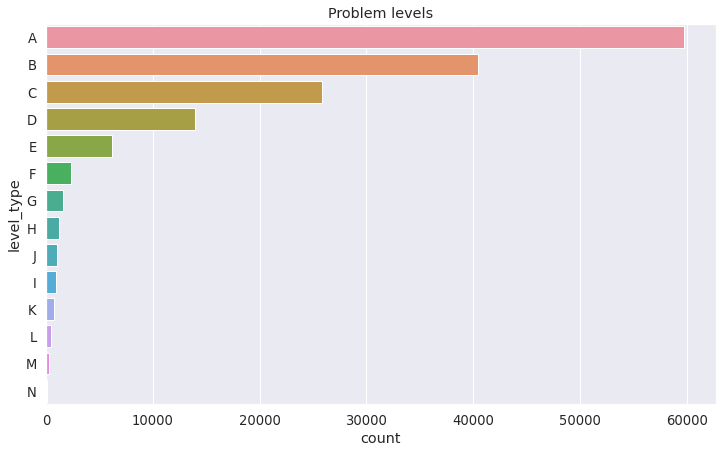

In [13]:
plt.figure(figsize=(12,7))
sns.set(font_scale=1.2)
sns.countplot(y='level_type', data=train, order=train.level_type.value_counts().index).set_title('Problem levels')
plt.show()

One way to find out if there is a correlation between level_type and difficulty is by checking the points assigned for problems at the various levels since challenging problems fetch greater points.

Level_type & Points

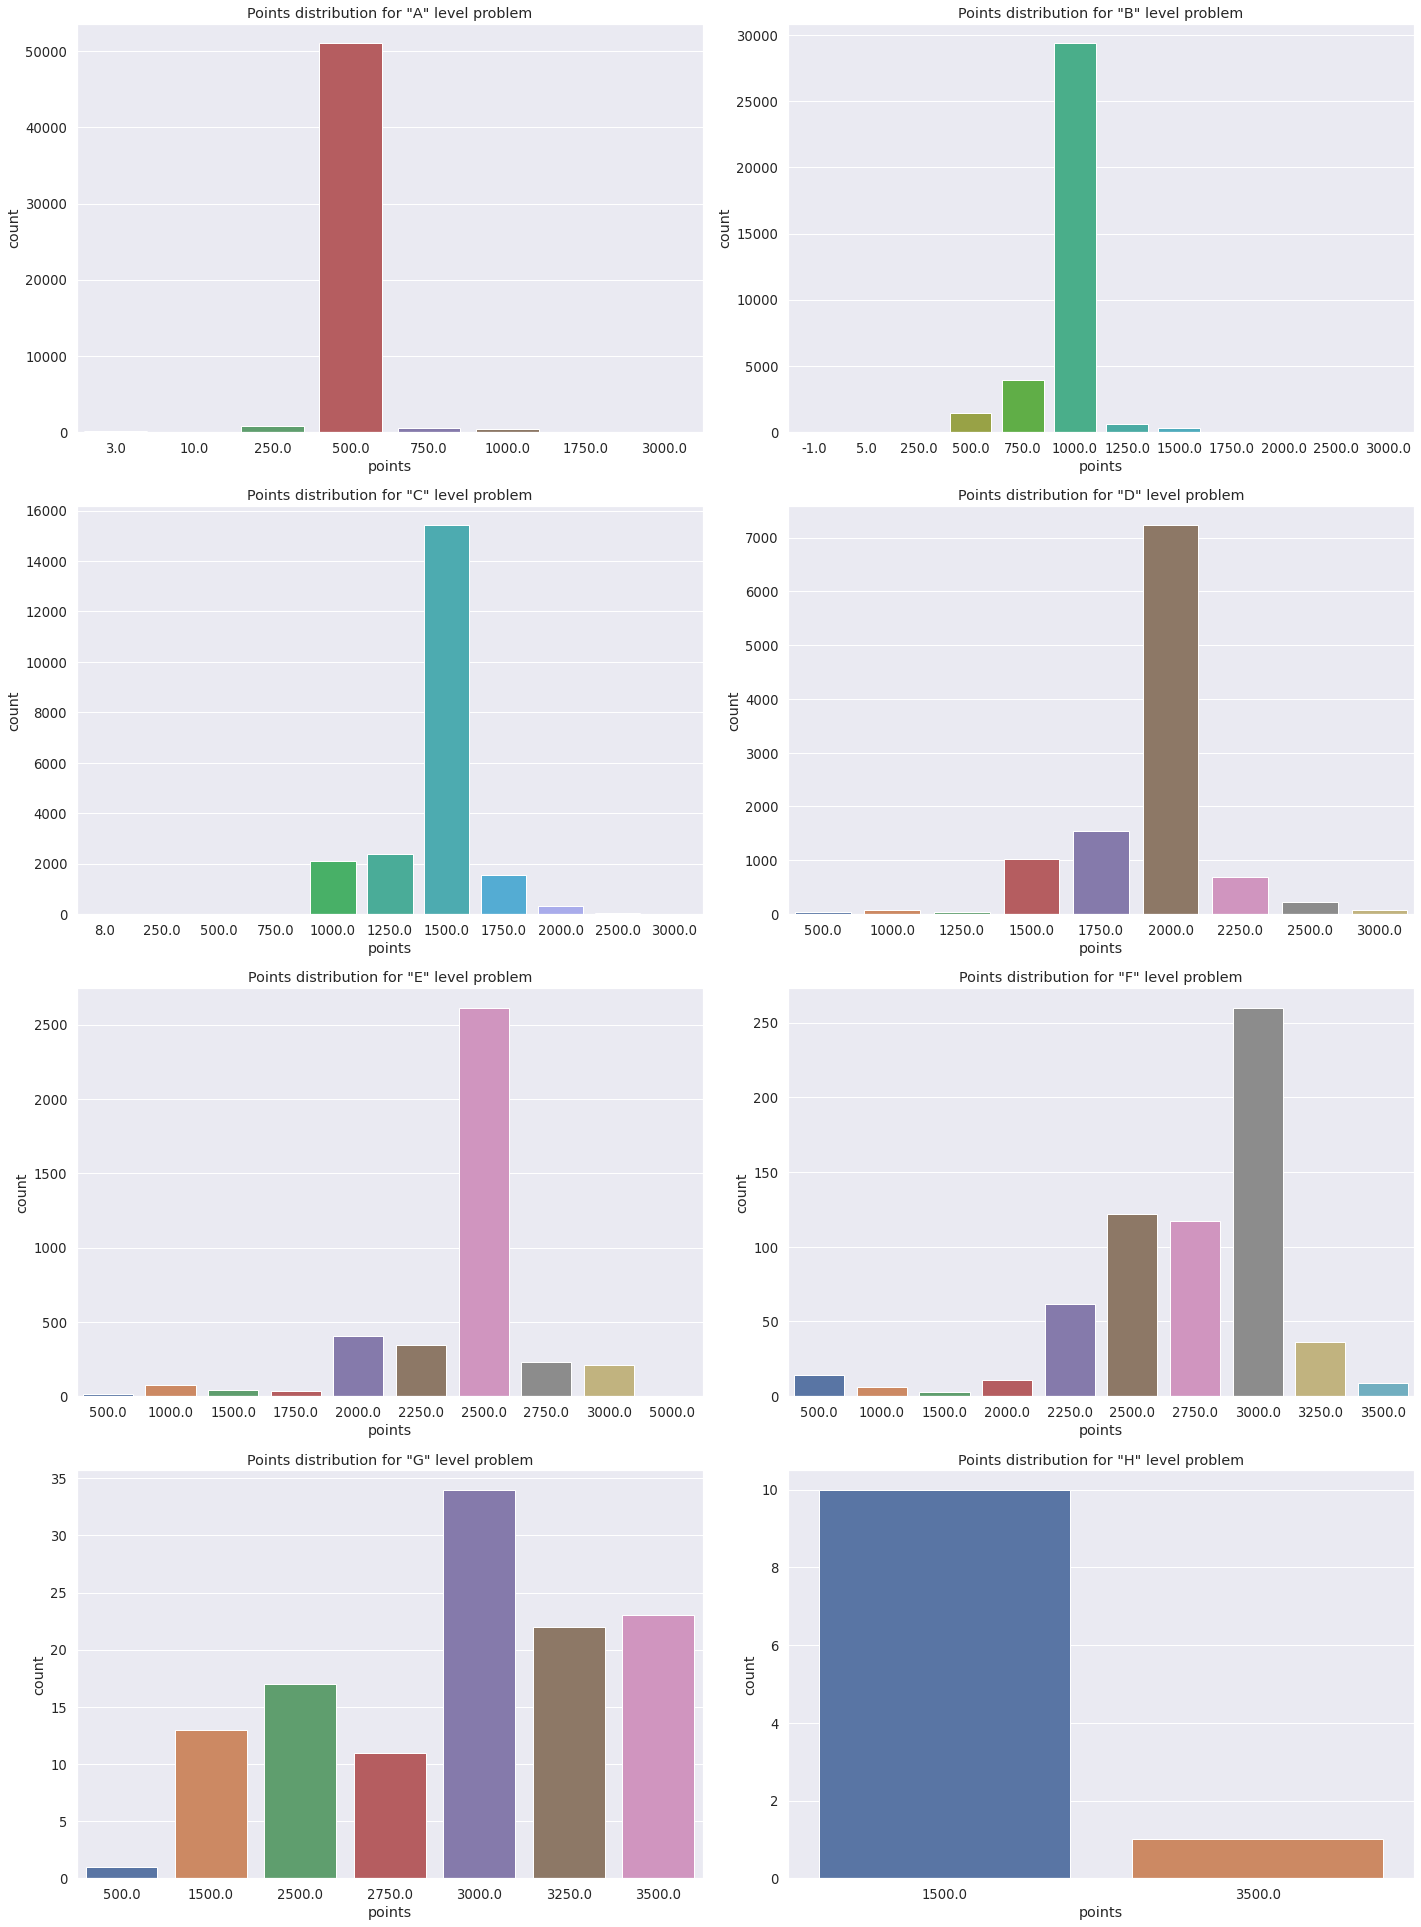

In [14]:
fig, axes = plt.subplots(4,2)
fig.set_size_inches(20,27)
sns.countplot(train['points'][train.level_type=='A'], ax=axes[0][0]).set_title('Points distribution for "A" level problem')
sns.countplot(train['points'][train.level_type=='B'], ax=axes[0][1]).set_title('Points distribution for "B" level problem')
sns.countplot(train['points'][train.level_type=='C'], ax=axes[1][0]).set_title('Points distribution for "C" level problem')
sns.countplot(train['points'][train.level_type=='D'], ax=axes[1][1]).set_title('Points distribution for "D" level problem')
sns.countplot(train['points'][train.level_type=='E'], ax=axes[2][0]).set_title('Points distribution for "E" level problem')
sns.countplot(train['points'][train.level_type=='F'], ax=axes[2][1]).set_title('Points distribution for "F" level problem')
sns.countplot(train['points'][train.level_type=='G'], ax=axes[3][0]).set_title('Points distribution for "G" level problem')
sns.countplot(train['points'][train.level_type=='H'], ax=axes[3][1]).set_title('Points distribution for "H" level problem')
plt.tight_layout()

We can see a consistent increase in points from level A to G. So difficulty level increases from A to H. 

**Tags**

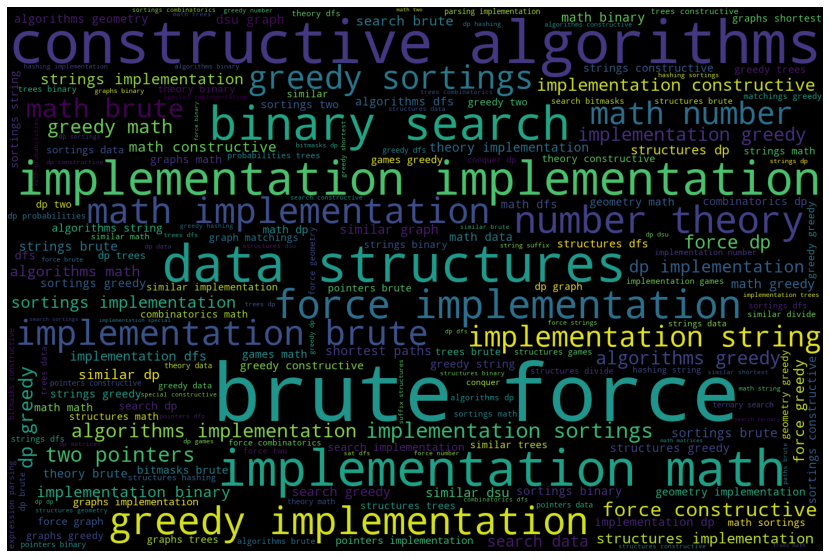

In [15]:
tags = train.tags.str.split(',')
tags = tags.dropna()
text = tags.explode().to_list()
wc = WordCloud(width=1500, height=1000).generate(' '.join(text))
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(wc)
plt.show()

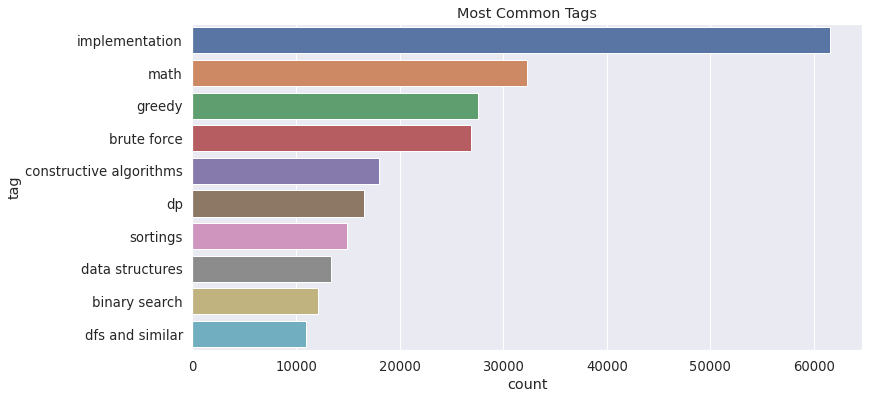

In [16]:
tag_counts = Counter(text)
tag_counts = dict(tag_counts.most_common(10))
tag_counts = pd.DataFrame(tag_counts.items(), columns = ['tag', 'count'])
plt.figure(figsize=(12,6))
sns.barplot(x='count', y='tag', data=tag_counts).set_title('Most Common Tags')
plt.show()

Ploblems solved by users at various levels

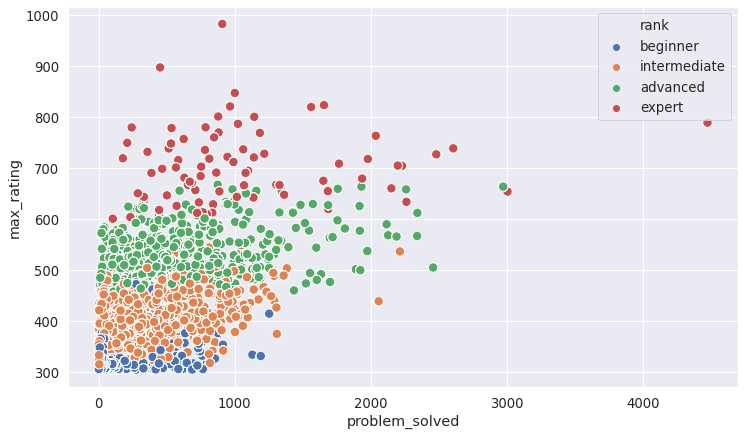

In [17]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='problem_solved', y='max_rating', hue='rank', data=train, s=85)
plt.show()

One can see a strong correlation between rank and max_rating. It is usually the case that skilled programmers get higher ratings and usually tend to solve more problems than entry level programmers, this correlation can be seen in the figure.

**Users from top 10 countries**

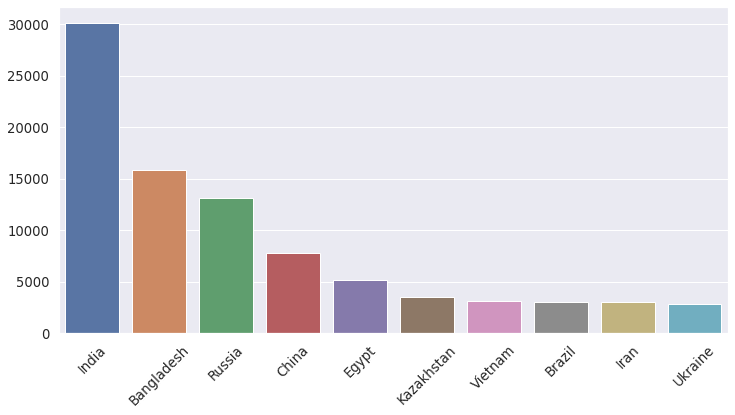

In [18]:
top10countries = train.country.value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top10countries.index, y=top10countries.values)
plt.xticks(rotation=45)
plt.show()

Top 10 countries among experts

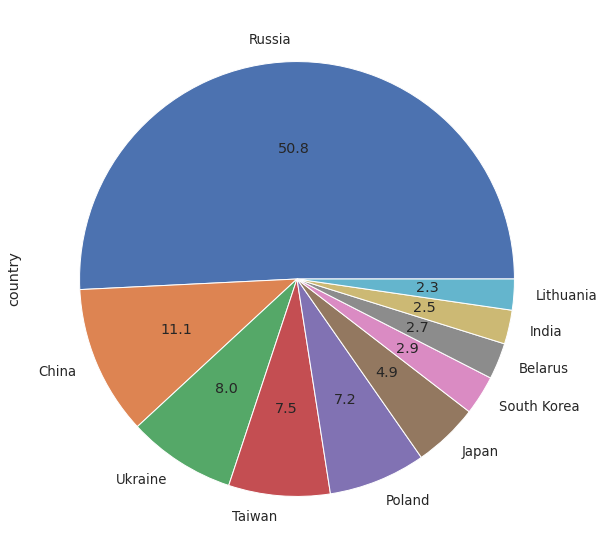

In [19]:
expert = train[['country','rank','level_type','attempts_range']][train['rank']=='expert']
exp = expert['country'].value_counts().head(10)
exp.plot.pie(y=exp.values, figsize=(10,10), autopct='%.1f')
plt.show()

Even though overall users from India are the maximum at about 30K, maximum experts are from Russia follwed by China and Ukraine. 

Top 10 countries among advanced participants

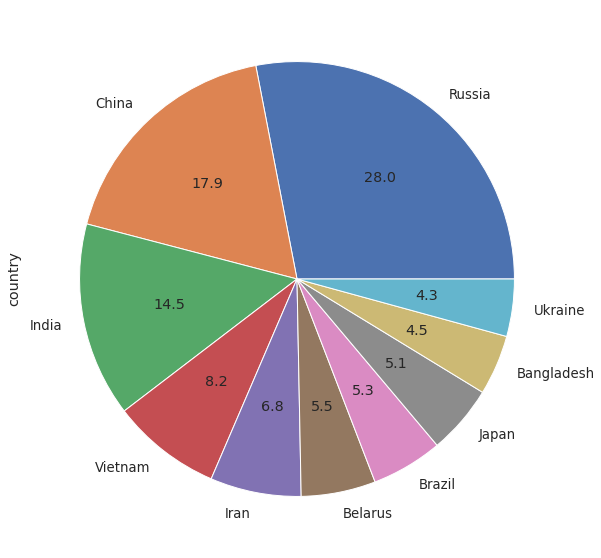

In [20]:
advanced = train[['country','rank','level_type','attempts_range']][train['rank']=='advanced']
adv = advanced['country'].value_counts().head(10)
adv.plot.pie(y=adv.values, figsize=(10,10), autopct='%.1f')
plt.show()

Top 10 countries among intermediate level users

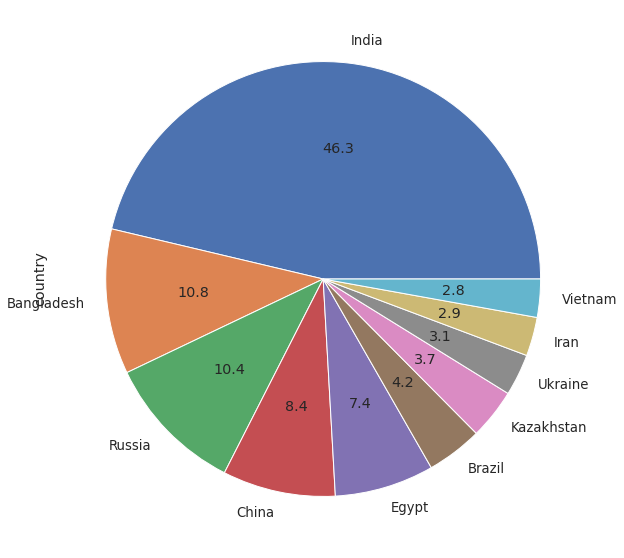

In [21]:
intermediate = train[['country','rank','level_type','attempts_range']][train['rank']=='intermediate']
inter = intermediate['country'].value_counts().head(10)
inter.plot.pie(y=inter.values, figsize=(10,10), autopct='%.1f')
plt.show()

Top 10 countries among beginners

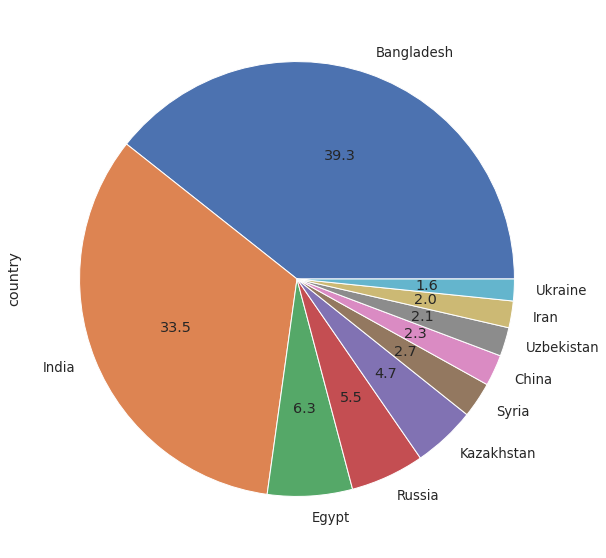

In [22]:
beginner = train[['country','rank','level_type','attempts_range']][train['rank']=='beginner']
beg = beginner['country'].value_counts().head(10)
beg.plot.pie(y=beg.values, figsize=(10,10), autopct='%.1f')
plt.show()

Majority of the advanced and expert users are from Russia and China whereas a vast majority of participants at beginner and intermediate levels are from Bangladesh and India.

**Problem level and users**

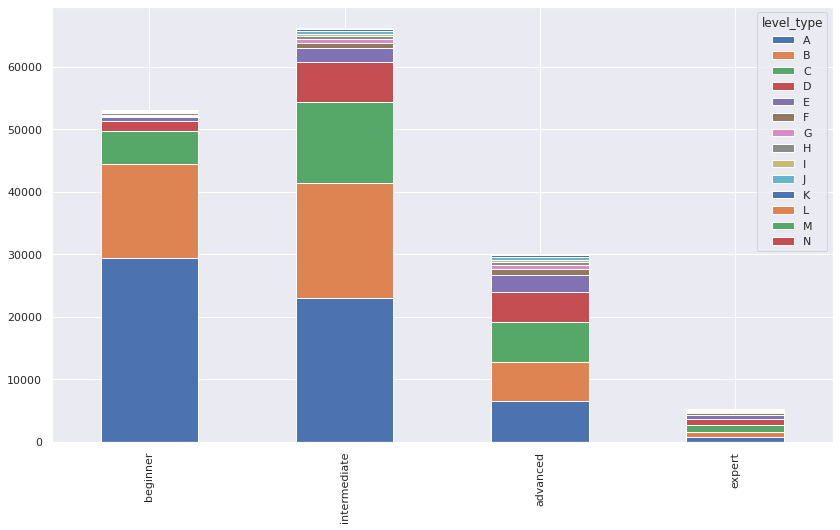

In [23]:
rank_prob_level = pd.DataFrame()
rank_prob_level['beginner'] = beginner.level_type.value_counts().sort_index()
rank_prob_level['intermediate'] = intermediate.level_type.value_counts().sort_index()
rank_prob_level['advanced'] = advanced.level_type.value_counts().sort_index()
rank_prob_level['expert'] = expert.level_type.value_counts().sort_index()

rank_prob_level = rank_prob_level.reset_index().rename(columns={'index':'level_type'})

sns.set(rc={'figure.figsize':(14,8)})
rank_prob_level.set_index('level_type').T.plot(kind='bar', stacked=True)
plt.show()

Beginners submitted more problems at the entry level. Levels A, B and C comprise the biggest chunk of all problems solved by beginners. More skilled users submitted a significant number of higher level problems. Advanced and expert users have almost equal share of problems at all the levels present in the group.

**Attempts_range and Users**

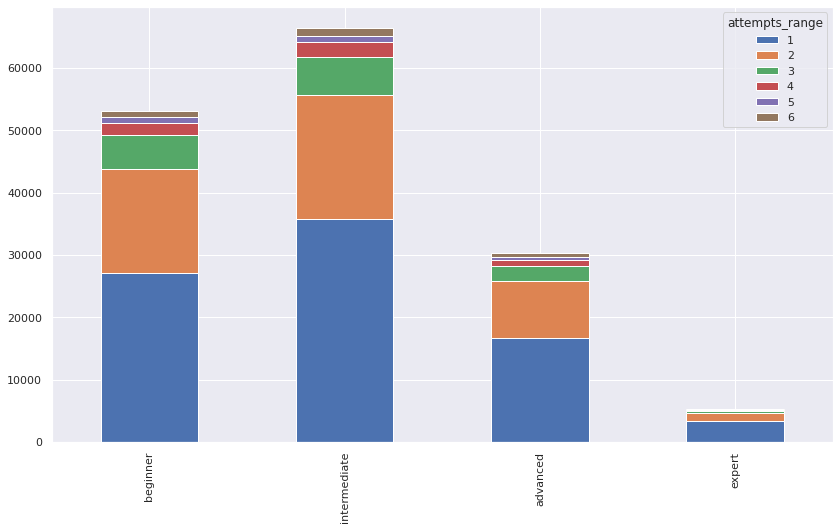

In [24]:
attempts_range = pd.DataFrame()
attempts_range['beginner'] = beginner.attempts_range.value_counts().sort_index()
attempts_range['intermediate'] = intermediate.attempts_range.value_counts().sort_index()
attempts_range['advanced'] = advanced.attempts_range.value_counts().sort_index()
attempts_range['expert'] = expert.attempts_range.value_counts().sort_index()

attempts_range = attempts_range.reset_index().rename(columns={'index':'attempts_range'})

sns.set(rc={'figure.figsize':(14,8)})
attempts_range.set_index('attempts_range').T.plot(kind='bar', stacked=True)
plt.show()

**Problem level and Attempts_range**

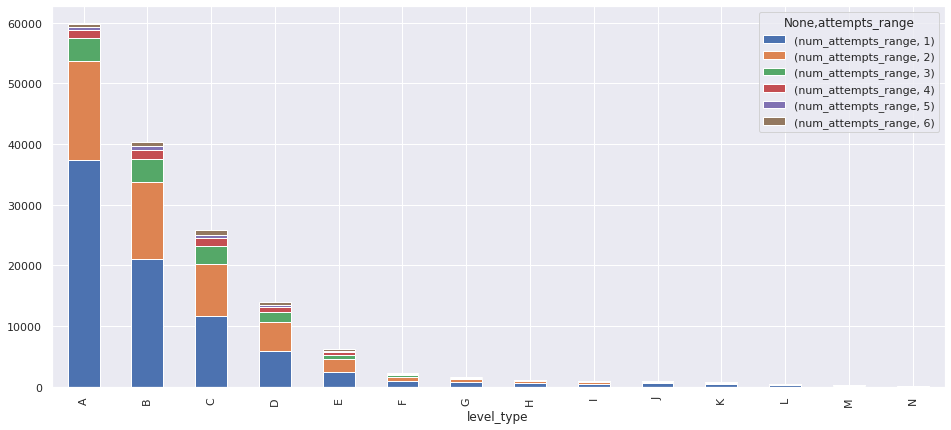

In [25]:
prob_lvl_attempts = train[['level_type', 'attempts_range']]
prob_lvl_attempts = pd.DataFrame(prob_lvl_attempts.groupby(['level_type','attempts_range'])['attempts_range'].agg('count'))
prob_lvl_attempts = prob_lvl_attempts.rename(columns={'attempts_range':'num_attempts_range'})
prob_lvl_attempts = prob_lvl_attempts.reset_index()

data = prob_lvl_attempts.set_index(['level_type', 'attempts_range'])
sns.set(rc={'figure.figsize':(16,7)})
data.unstack().plot(kind='bar', stacked=True)
plt.show()

# Feature Engineering

In [26]:
train.head()

,user_id,problem_id,attempts_range,level_type,points,tags,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds
0,user_232,prob_6507,1,B,1000.0,strings,53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935
1,user_232,prob_5071,4,A,500.0,implementation,53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935
2,user_232,prob_703,2,A,500.0,"brute force,implementation",53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935
3,user_232,prob_3935,1,C,1000.0,"greedy,sortings",53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935
4,user_232,prob_164,2,A,500.0,"brute force,constructive algorithms,math",53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935


**Tags column**

Tags column contains problem tags which give a sense of the type of problem and therefore hold useful information for a model. Some rows contain multiple tags. It is a good idea to create separate columns for each tag and apply binary coding to indicate its presence or absence in a problem. One hot encoding tags for both train and test data.

In [27]:
train = pd.concat([train.drop('tags', axis=1), train.tags.str.get_dummies(sep=',').add_prefix('tag_')],1)

#one-hot encode test data
test = pd.concat([test.drop('tags', axis=1), test.tags.str.get_dummies(sep=',').add_prefix('tag_')],1)

**Level type**

Level type must be converted to numeric encoding from letter encoding. However there are sum NA values which have to be dealth with before applying encoder.

In [28]:
print(f'Percent of NaN in train level_type: {(train.level_type.isna().sum()/train.shape[0]*100):.2f}%')
print(f'Percent of NaN in test level_type: {(test.level_type.isna().sum()/test.shape[0]*100):.2f}%')

Percent of NaN in train level_type: 0.40%
Percent of NaN in test level_type: 0.43%


As the missing values are only a tiny proportion of data. I will fill the blanks with the mode value.

In [29]:
train['level_type'] = train['level_type'].fillna('A')
test['level_type'] = test['level_type'].fillna('A')

In [30]:
# now LabelEncoder can be applied on level_type
le = LabelEncoder()
train['level_type'] = le.fit_transform(train['level_type'])
test['level_type'] = le.transform(test['level_type'])

**Rank**

Label encode rank in train and test set

In [31]:
le = LabelEncoder()
train['rank'] = le.fit_transform(train['rank'])
test['rank'] = le.transform(test['rank'])

**User id and Problem id**

User id and problem id have prefix - user_ and prob_ before the id number. Remove the prefix and only keep numerical id.

In [32]:
train['user_id'] = train['user_id'].str[5:].astype(int)
test['user_id'] = test['user_id'].str[5:].astype(int)

train['problem_id'] = train['problem_id'].str[5:].astype(int)
test['problem_id'] = test['problem_id'].str[5:].astype(int)

**Country**

In [33]:
print(f'Percent of NaN in train country: {(train.country.isna().sum()/train.shape[0]*100):.2f}%')
print(f'Percent of NaN in test country: {(test.country.isna().sum()/test.shape[0]*100):.2f}%')

Percent of NaN in train country: 24.37%
Percent of NaN in test country: 24.28%


Country is missing for almost one-fourth of train as well as test data. This issue can be fixed in the following ways:

i. **Drop rows with missing data:** This approach will discard 25% of available data. This would lead to loss of important information which may otherwise be used for predicting the target. Obviosuly this should be avoided if possible.

ii. **Fill missing values with aggregate values such as mode:** This approach most likely will lead to better results than the first approach however the variable's predictive capacity would get compromised if significant number of artificial entries are added.

iii. **Impute missing values from available values in the table:** This approach works better than the first two approaches in many situations even though it may not yield the best results as we are imputing the missing values which may differ from the actual values. 

Sklearn provides IterativeImputer, a multivariate imputer that estimates missing features from all the other features. It works only with numeric data. Therefore string values in 'country' have to be converted to numeric values before applying imputer on the data.

I will do the following to impute missing countries:

* Impute the missing 'points' after dropping country
* Fit LabelEncoder on countries in train set
* Create a dictionary that maps countries and numeric codes
* Map the countries using the dictionary
* Apply IterativeImputer on train and test sets to impute missing countries. 

In [34]:
imp = IterativeImputer()  #instantiate IterativeImputer
#transform train set
train_country = train.pop('country')
train_cols = train.columns
train = pd.DataFrame(imp.fit_transform(train), columns = train_cols) #fit imputer & transform data
train = train.astype(int)
train['country'] = train_country

#transform test set
test_country = test.pop('country')
test_cols = test.columns
test = pd.DataFrame(imp.fit_transform(test), columns = test_cols)
test = test.astype(int)
test['country'] = test_country

In [35]:
#Encode country names to numeric values
le = LabelEncoder()
le_tr = le.fit(train['country'].dropna())
country_map = dict(zip(le.classes_, range(len(le.classes_)))) # dictionary maps country to numeric code
train['country'] = train['country'].map(country_map)
test['country'] = test['country'].map(country_map)

In [36]:
#Once again use imputer to impute missing values in the final column
imp = IterativeImputer()
train_cols = train.columns
train = pd.DataFrame(imp.fit_transform(train), columns = train_cols)
train = train.astype(int)

test_cols = test.columns
test = pd.DataFrame(imp.fit_transform(test), columns = test_cols)
test = test.astype(int)

Check if there are any null values in train and test sets

In [37]:
print(train.isna().sum().any())
print(test.isna().sum().any())

False
False


In [38]:
X_train = train.drop('attempts_range', axis=1)
y_train = train['attempts_range']

In [39]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'test.shape: {test.shape}')

X_train.shape: (155295, 50)
y_train.shape: (155295,)
test.shape: (66555, 50)


# Modeling

# 1. Random Forest Classifier with default params

First, I would fit a RandomForestClassifier with default parameters and look at the feature importances. As the competition uses Weighted F1 score, I will pass the same scoring metrics in cross validation with 4 splits. 

In [40]:
forest = RandomForestClassifier()
rf = cross_val_score(forest, X_train, y_train, scoring = 'f1_weighted', cv=4)
print(rf)
print('')
print(np.mean(rf))

[0.47770262 0.4682186  0.46754558 0.46883545]

0.47057556284926116


**Plot Feature imortances**

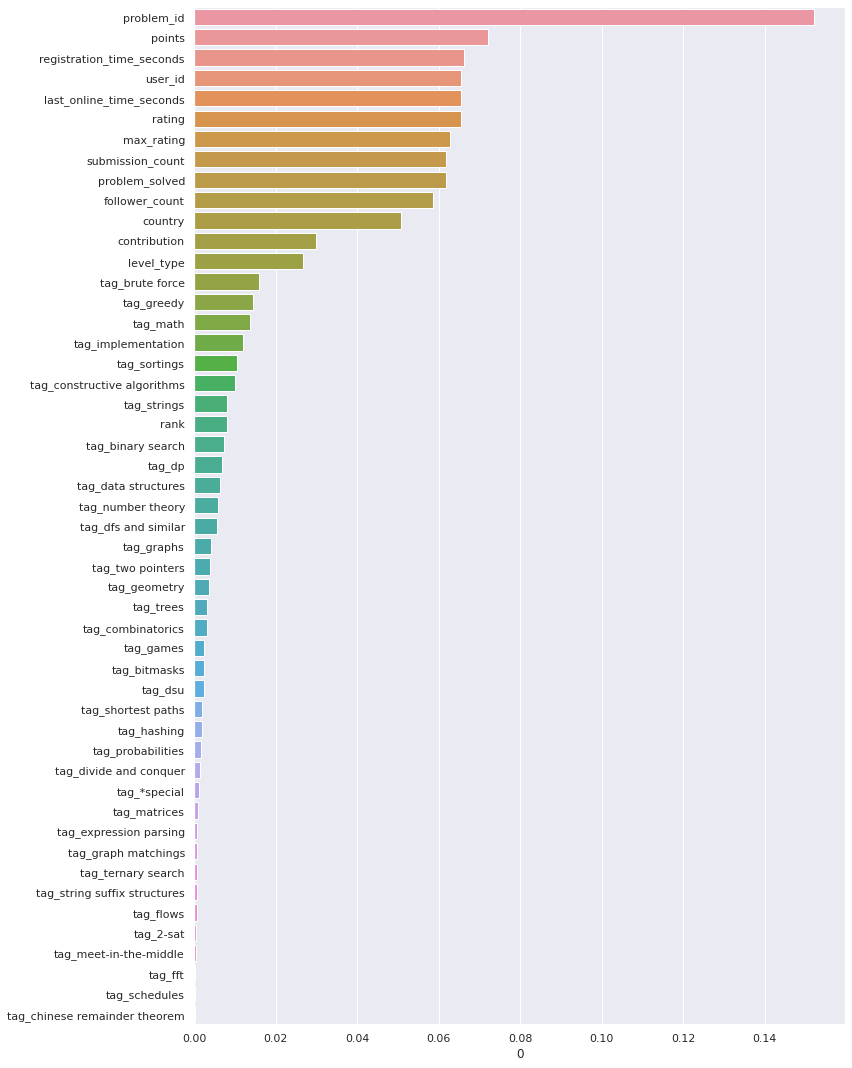

In [41]:
forest.fit(X_train, y_train)
feat_imp = pd.DataFrame(forest.feature_importances_, index=X_train.columns)
feat_imp = feat_imp.sort_values(by=0, ascending=False)

#plot feature importances
plt.figure(figsize=(12,15))
sns.barplot(x=feat_imp[0], y=feat_imp.index)
plt.tight_layout()

# Split data into train and test sets

In [42]:
x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1)

# 2. RandomizedSearchCV on RandomForestClassifier

I will use RandomizedSearchCV on RandomForestClassifier to see if it results in performance improvement over the default classifier.

In [43]:
# set parameter range for randomized search
param_distributions = dict(
    n_estimators = [100, 200, 500],
    max_depth = [4, 8, 12, None],
    min_samples_split = [2, 4, 6],
    max_features = ['sqrt', 'log2'],
    max_samples = [0.6, 0.8, 1.0]
    
)

rf2 = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_distributions, scoring = 'f1_weighted', cv=4)
rf2.fit(x_tr, y_tr) # fit the best model on train set

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [4, 8, 12, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'max_samples': [0.6, 0.8, 1.0],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [100, 200, 500]},
                   scoring='f1_weighted')

In [44]:
rf_pred_y_tr = rf2.predict(x_tr) # get model predictions of train set
rf_pred_y_te = rf2.predict(x_te) # get model predictions of test set

#Print the F1 score for train and test sets
print(f"train f1-score: {f1_score(y_tr, rf_pred_y_tr, average= 'weighted')}") 
print(f"test f1-score: {f1_score(y_te, rf_pred_y_te, average= 'weighted')}")

train f1-score: 0.9637095262752804
test f1-score: 0.493450933686061


There is an improvement in the second model's performance on the test set. However, there is an issue of overfitting. Let's see what are the best parameters.

In [45]:
print(rf2.best_params_)

{'n_estimators': 500, 'min_samples_split': 4, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': None}


# 3. XGBoost Classifier

In [46]:
xgb = XGBClassifier(max_depth=16, eta=0.12) #max_depth and eta were set after hyperparamter tuning 
xgb.fit(x_tr, y_tr) #fit model on train set
xgb_pred_y_te = xgb.predict(x_te) #predict on test set
xgb_pred_y_tr = xgb.predict(x_tr) #predict on train set
print(f"train f1-score: {f1_score(y_tr, xgb_pred_y_tr, average= 'weighted')}")
print(f"test f1-score: {f1_score(y_te, xgb_pred_y_te, average= 'weighted')}")

train f1-score: 0.9423646922257592
test f1-score: 0.5426174435246485


There is a further improvement in F1 score on test set although it is not much. 

# 4. Stacking of XGBoost and RandomForestClassifier

Sometimes, stacked classifiers do a significantly better job than single classifiers. I will stack a XGBClassifier and RandomForestClassifier with tuned parameters and use another XGBClassifier with default params as final estimator.

In [47]:
estimators = [('xgb1', XGBClassifier(max_depth=16, eta=0.12)), 
               ('rf', RandomForestClassifier(n_estimators=200, min_samples_split=4, max_samples=0.8, min_impurity_split=0.2)),
             ]

clf = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier())
clf.fit(x_tr, y_tr)

StackingClassifier(estimators=[('xgb1',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, eta=0.12,
                                              gamma=None, gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None, max_depth=16,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_est...
                                             

In [48]:
clf_pred_y_tr = clf.predict(x_tr)
clf_pred_y_te = clf.predict(x_te)

In [49]:
print(f"train f1-score: {f1_score(y_tr, clf_pred_y_tr, average= 'weighted')}") 
print(f"test f1-score: {f1_score(y_te, clf_pred_y_te, average= 'weighted')}")

train f1-score: 0.7738896838204484
test f1-score: 0.5460672255992297


In this case, stacking the classifiers did not lead to an improvement on test performance.

# Model Selection 

Among all the models tested, the third model did a relativelely better job than the other three models. Hence I would select it as the final model.

In [50]:
# Fit the selected model on the entire train set
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.12, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.119999997, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Make predictions on test data**

In [51]:
y_test_pred = xgb.predict(test)

# Generate Submission File

In [52]:
#create a new dataframe and populate test ids & predictions in it
my_sub = pd.DataFrame()
my_sub['ID'] = test_ids
my_sub['attempts_range'] = y_test_pred
#load test file
test1 = pd.read_csv('../input/avrecommendation-system/AV-Recommendation Engine/test_submissions_NeDLEvX.csv')
#align test ids in the same order as they are in the test file
test1 = test1.merge(my_sub, on='ID').drop(['user_id', 'problem_id'],axis=1)
#generate CSV file
test1.to_csv('Recommendation Engine Submission.csv', index=False)